In [28]:
%%capture
%run 07_Recaliberate_DistanceModulus.ipynb

In [29]:
!pip install tqdm

In [30]:
import emcee
import corner
import scipy
import numpy as np

In [31]:
#Omega_M = 0.286
z = filtered_GRB['z'].to_numpy()
H_0 = 70 # km/sec/Mpc
c = 299792.458 # km/s

In [32]:
# convert cm to Mpc
d_L_ = d_L / (10**6 * 3.086e+18)
d_L_err = d_L_err / (10**6 * 3.086e+18)

In [39]:
def HubbelParameter(z, Omega_M):
    return H_0 * np.sqrt((Omega_M * (1+z)**3 + 1 - Omega_M))

def integrand(z, Omega_M):
    Hz = HubbelParameter(z, Omega_M)
    return 1. / HubbelParameter(z, Omega_M)

def luminosity_distance(z, Omega_M):
    vfunc = np.vectorize(integrand)
    r,e = scipy.integrate.quad(vfunc,0.1,z,args=(Omega_M))
    return c * (1. + z) *r

print(luminosity_distance(0.84, 0.286)) # sanity-check

4597.358544821771


Below is shown estimating Omega in two different techniques
1. using scipy.optimize.fsolve
2. emcee tool

## 1. scipy.optimize.solve

In [45]:
def func(Omega_M, d_L, z) :
    return d_L - luminosity_distance(z, Omega_M)

vfunc = np.vectorize(func)

Omega_M_guess = 0.27

Omega_M_sum = 0
count = 0;
for i in range(d_L_.shape[0]):
    if d_L_err[i] > 3000:  continue # ignore large errors
    Omega_M, = scipy.optimize.fsolve(func, Omega_M_guess, args=(d_L_[i], z[i]))
    #print(Omega_M)
    Omega_M_sum += Omega_M
    count += 1

Omega_M = Omega_M_sum / count
print(f'Omega_M {Omega_M}')

/tmp/ipykernel_1111141/3141936610.py:2: RuntimeWarning: invalid value encountered in sqrt
  return H_0 * np.sqrt((Omega_M * (1+z)**3 + 1 - Omega_M))
/tmp/ipykernel_1111141/3141936610.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  r,e = scipy.integrate.quad(vfunc,0.1,z,args=(Omega_M))


Omega_M 0.4163798149570552


## 2. emcee

In [47]:
def luminosity_distance(z, Omega_M):
    vfunc = np.vectorize(integrand)
    r  = [scipy.integrate.quad(vfunc,0,zarray,args=(Omega_M))[0] for zarray in z]
    return c * (1. + z) *r

In [48]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

  0%|                                                  | 0/5000 [00:00<?, ?it/s]/home/shreeprasad/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████| 5000/5000 [02:48<00:00, 29.61it/s]


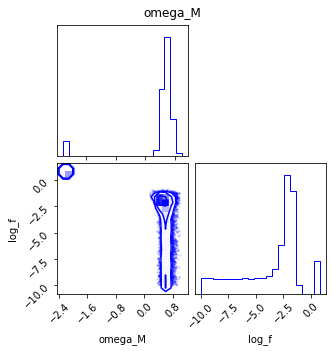

In [49]:
def log_likelihood(theta, x, y, yerr):
    m, log_f = theta
    model = luminosity_distance(x, m)
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    m, log_f = theta
    if 0 < m < 1. and -10.0 < log_f < 10.0:
        return 0.0
    return -np.inf

def log_posterior(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

# MCMC parameters
nwalkers, ndim = 16,2#64, 2
nsteps, nburns = 5000, 1000

# create empty figure object for corner plots (confidence contours and marginalized PDFs of parameters)
fig2 = plt.figure(figsize=(5, 5))
fig2.patch.set_facecolor('white')

x = z
y = d_L_

yerr = d_L_err

rng = np.random.default_rng(123)
starting_guesses = rng.normal(0, 1, (nwalkers, ndim))
from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, pool=pool, args=(x, y, yerr))
    sampler.run_mcmc(starting_guesses, nsteps, progress=True)

'''
# time series plot of parameters
samples = sampler.get_chain()
gs11 = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=1, subplot_spec=gs1[k])

for j in range(ndim):
    ax = fig1.add_subplot(gs11[j])
    ax.plot(samples[..., j], 'k', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    #axes[-1].set_xlabel("step number");
'''
# corner plots
flat_samples = sampler.get_chain(discard=nburns, flat=True)
corner.corner(flat_samples, labels=['omega_M','log_f'], color='b',fig=fig2)

# save best fit values(mean) and uncertainities(std) of parameters in a dictionary
omega_M_correlation_best_fit = {
        'omega_M' : np.mean(flat_samples[:,0]), 
        'omega_M_err' : np.std(flat_samples[:,0]),
        'sigma_int' : np.mean(flat_samples[:, 1]),
        'sigma_int_err' : np.std(flat_samples[:, 1])
    }

#fig2.axes[0].annotate(sample_type, xy=(0.95*2.5, 0.95-k*0.2), xycoords='axes fraction',color=color)

fig2.suptitle('omega_M')

#fig1.savefig('time_series_of_params.png')
fig2.savefig(os.path.join(out_dir,'18_omega_M_corner_plot.png'))
#fig1.show()
fig2.show()

In [50]:
print('omega_M = {}'.format(omega_M_correlation_best_fit['omega_M']))
print('omega_M_err = {}'.format(omega_M_correlation_best_fit['omega_M_err']))

print('omega_L = {}'.format(1 - omega_M_correlation_best_fit['omega_M']))
print('omega_L_err = {}'.format(omega_M_correlation_best_fit['omega_M_err']))

omega_M = 0.39895701738765715
omega_M_err = 0.6820023533923348
omega_L = 0.6010429826123429
omega_L_err = 0.6820023533923348
